## Fitting time series models in the time domain

In [1]:
# Imports
import numpy as np
import scipy.stats as stats
from scipy import signal
import statsmodels.tsa as tsa
import statsmodels.api as sm
from scipy import ndimage
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
# Add an import for models in future versions

In [2]:
def plot_acf(series, lags = 40):
    series_acf = acf(series, nlags = lags, fft = True)
    fig, ax = plt.subplots(2,1, figsize = (9,6))
    # Plot series
    ax[0].plot(series)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Series')
    # Plot autocorrelation
    threshold = 1.96/np.sqrt(len(series))
    ax[1].stem(series_acf)
    ax[1].hlines(threshold, xmin = 0, xmax = 40, 
                 color = 'r', linestyle = '--')
    ax[1].hlines(-threshold, xmin = 0, xmax = 40, 
                 color = 'r', linestyle = '--')
    ax[1].set_xlabel('Lags')
    ax[1].set_ylabel('ACF')
    plt.tight_layout()
    plt.show()

In [3]:
class WhiteNoise:
    def __init__(self, mean = 0, variance = 1):
        self.mean = mean
        self.variance = variance
        self.distribution = stats.norm(
            loc = self.mean,
            scale = np.sqrt(self.variance)
        )
    
    def generate(self, n_steps):
        return self.distribution.rvs(size = n_steps)
    

In [4]:
class RandomWalk:
    
    def __init__(self, mean = 0, variance = 1):
        self.mean = mean
        self.variance = variance
        self.steps = stats.norm( loc = self.mean, 
                                  scale = np.sqrt(self.variance)
                                 )
        
    def generate(self, n_steps):
        walk = self.steps.rvs( size = n_steps).cumsum()
        return walk

In [5]:
signal.lfilter(
    b = np.array([1, 2, 3]), 
    a = 1.0,
    x = np.random.rand(20))

array([0.52252675, 1.80966369, 3.89792118, 4.6091206 , 4.28621062,
       3.59645708, 2.8872613 , 2.67787536, 1.82791026, 1.42107368,
       1.65017157, 2.37170449, 1.96782091, 3.59741784, 3.7360026 ,
       4.57539991, 4.06072858, 3.99801073, 1.92979135, 0.89678207])

In [6]:
class MAProcess:
    # X_t = theta(B)Z_t = (beta_0*I + beta_1*B +... + beta_q*B^q )Z_t 
    # B is the shift matrix
    # B^j Z_t = Z_{t-j}
    # 
    
    def __init__(self, coefficients, mean = 0, variance = 1, beta_0 = 1):
        self.underlying = stats.norm( loc = mean,scale = np.sqrt(variance))
        self.order = len(coefficients) - 1
        self.beta_0 = beta_0
        self.coefficients = np.insert(coefficients, 0, self.beta_0)
        
    def generate(self, n_steps):
        z = self.underlying.rvs( size = n_steps)
        ma_series = signal.lfilter(self.coefficients, 1.0, z)
        return ma_series  

In [7]:
class ARProcess:
    
    def __init__(self, coefficients, mean = 0, variance = 1):
        self.underlying = stats.norm( loc = mean,
                                     scale = np.sqrt(variance))
        self.order = len(coefficients) - 1
        self.coefficients = np.array(coefficients)
    
    def generate(self, n_steps, method = 1):
        np.random.seed(seed=233423)
        z = self.underlying.rvs( size = n_steps)
        if method == 1:
            shifts = np.array([np.eye(n_steps, n_steps, -k)
                      for k in range(len(self.coefficients)+1)])
            weights = np.insert(-self.coefficients, 0, 1.0)
            psi = np.tensordot( # <- This performs a dot product of tensors
                weights, # <- shape = (len(coefficients) + 1)
                shifts, # <- shape = (len(coefficients) + 1, n_steps, n_steps)
                axes = ((0),(0))) # <- summing along specified axes

            ar_series = np.linalg.inv(psi) @ z
        if method == 2:
            ar_series = signal.lfilter(
                np.array([1.0]), # MA coefficients
                np.insert(-self.coefficients, 0, 1.0), # AR coefficients
                z # input signal
            )
        return ar_series  

In [8]:
class ARMAProcess:
    
    def __init__(self,ar_coefficients,ma_coefficients, mean = 0, variance = 1):
        self.underlying = stats.norm( loc = mean, 
                                     scale = np.sqrt(variance))
        self.ma_order = len(ma_coefficients) 
        self.ar_order = len(ar_coefficients) 
        self.ma_coefficients = np.array(ma_coefficients)
        self.ar_coefficients = np.array(ar_coefficients)
        
    
    def generate(self, n_steps):
        np.random.seed(seed=233423)
        z = self.underlying.rvs( size = n_steps)
        # ----------------- MA ---------
        # Generate Theta
        ma_shifts = np.array( 
            [np.eye(n_steps, n_steps, -k)  
             for k in range(len(self.ma_coefficients)+1)]
        )
        # weights = [1 , beta_1,beta_2, ..., beta_q]
        ma_weights = np.insert(self.ma_coefficients, 0, 1)
        # Inner product of vector beta (coef) and the shifts matrices: 
        # theta(B)  = (beta_0*I + beta_1*B +... + beta_q*B^q )
        theta = np.tensordot(ma_weights, ma_shifts, axes = ((0),(0))) 
        ma_series = theta @ z
        # Generate Psi
        ar_shifts = np.array([np.eye(n_steps, n_steps, -k)
                  for k in range(len(self.ar_coefficients)+1)])
        ar_weights = np.insert(-self.ar_coefficients, 0, 1.0)
        psi = np.tensordot( # <- This performs a dot product of tensors
            ar_weights, # <- shape = (len(coefficients) + 1)
            ar_shifts, # <- shape = (len(coefficients) + 1, n_steps, n_steps)
            axes = ((0),(0))) # <- summing along specified axes
        
        # ----------------- AR ---------
        arma_series = np.linalg.inv(psi) @ ma_series
        return arma_series    

In [9]:
class ARIMAProcess:

    
    def __init__(self,ar_coefficients,diff_order,ma_coefficients, mean = 0, variance = 1):
        self.underlying = stats.norm( loc = mean, 
                                     scale = np.sqrt(variance))
        self.ma_order = len(ma_coefficients) 
        self.ar_order = len(ar_coefficients) 
        self.ma_coefficients = np.array(ma_coefficients)
        self.ar_coefficients = np.array(ar_coefficients)
        self.diff_order = np.array(diff_order)

    
    
    def generate(self, n_steps):

        np.random.seed(seed=233423)
        z = self.underlying.rvs( size = n_steps)
        # ----------------- MA ---------
        ma_series = np.array([
            np.dot(
                np.insert(self.ma_coefficients,0,1.0) ,
                ndimage.shift(z, self.ma_order - t)[:self.ma_order + 1][::-1]
            ) for t in range(n_steps)]
        )
        # ----------------- AR ---------
        
        shifts = np.array([np.eye(n_steps, n_steps, -k)
                  for k in range(len(self.ar_coefficients)+1)])
        weights = np.insert(-self.ar_coefficients, 0, 1.0)
        # phi:
        phi = np.linalg.inv(
            np.tensordot( # <- This performs a dot product of tensors
                weights, # <- shape = (len(coefficients) + 1)
                shifts, # <- shape = (len(coefficients) + 1, n_steps, n_steps)
                axes = ((0),(0))) # <- summing along specified axes
        )
        # ------------------ Integration process -------------
        int_matrix =  np.linalg.matrix_power( (np.identity(n_steps) - np.eye(n_steps, n_steps, -1)), -self.diff_order )
        arma_series  = (phi @ ma_series)
        arima_series = int_matrix @ arma_series
        return arima_series    

### Estimating autocovariance and autocorrelation functions

Recall that the sample ac.f. of an observed time series $x_t, t = 1, \cdots, N$ at lag level $k < N$ is defined as 
$$
c_k = \sum_{t=1}^{N-k} \frac{(x_t - \bar{x})(x_{t+k} - \bar{x})}{N},
$$
where $\bar{x}$ denotes the sample mean. So long as $X_t$ is a stationary process, this is a biased estimator of the theoretical autocovariance coefficient $\gamma(k)$, whose bias can be shown to be $O(N^{-1})$. Moreover, the estimator is asymptotically unbiased, 
$$
\lim_{N \to \infty} E(c_k) = \gamma(k).
$$
The covariance of $C$ has the following structure, 
$$
\mathrm{Cov}(C_k, C_m) \approx \sum_{r = -\infty}^{\infty} \frac{\gamma(r)\gamma(r+m-k) + \gamma(r+m)\gamma(r-k)}{N}
$$
When $m=k$, this equation yields the variance of $C_k$, 
$$
\mathrm{Var}(C_k) \approx \sum_{r = -\infty}^{\infty} \frac{\gamma^2(r) + \gamma(r+k)\gamma(r-k)}{N}
$$
In particular, sucessive values of $c_k$ may be highly correlated, increasing the difficulty of interpreting the correlogram.

[Compare other estimators, add some of the proofs related to bias]

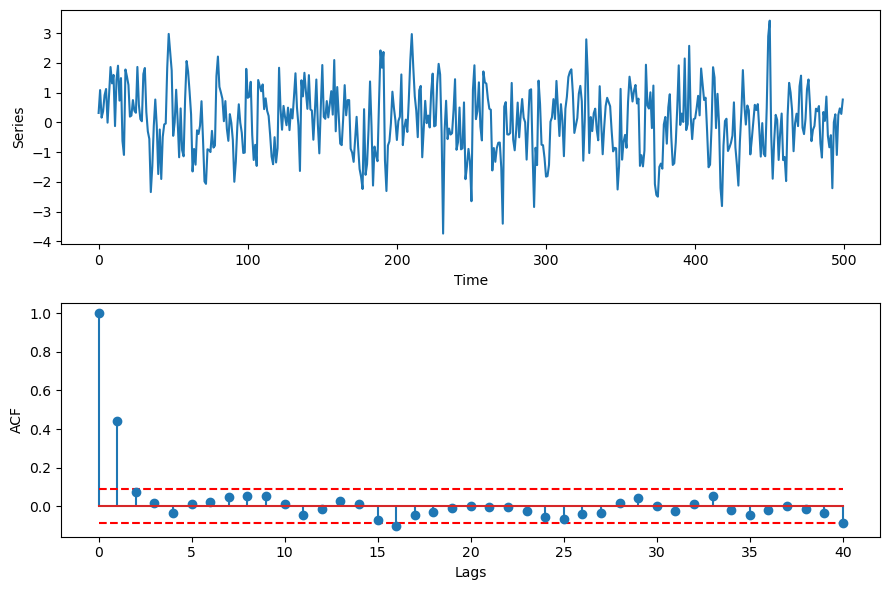

In [10]:
ma1_model = MAProcess([0.5])
ma1_series = ma1_model.generate(500)
ma1_acf = acf(ma1_series, nlags = 40, fft = True)
plot_acf(ma1_series)

In [11]:
ma1_sample_mean = ma1_series.mean()
ma1_sample_mean

0.05341098076818834

In [12]:
var_mean_estimator = ma1_series.var()/500
var_mean_estimator

0.0024851760979226773

In [13]:
var_corrected = var_mean_estimator*(1 + 2*np.array([1 - r/500 for r in range(1,40)])@ma1_acf[1:40])
var_corrected

0.003481112777137929

In [14]:
%%timeit
ar1_model = ARProcess([0.7])
ar1_series = ar1_model.generate(500, method = 1)
#ar1_acf = acf(ar1_series, fft = True, nlags = 40)
#plot_acf(ar1_series)

13.7 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
ar1_model = ARProcess([0.7])
ar1_series = ar1_model.generate(500, method = 2)
#ar1_acf = acf(ar1_series, fft = True, nlags = 40)
#plot_acf(ar1_series)

In [18]:
var_mean_estimator = ar1_series.var()/500
var_mean_estimator

0.003997938750635412

In [22]:
var_corrected = var_mean_estimator*(1 + 2*np.array([1 - r/500 for r in range(1,60)])@acf(ar1_series, nlags = 60,  fft = True)[1:60])
var_corrected

0.004863513691067119

In [23]:
(1-0.3)/(1+0.3)

0.5384615384615384

In [24]:
(var_corrected/var_mean_estimator)**(-1)

0.8220268317489224

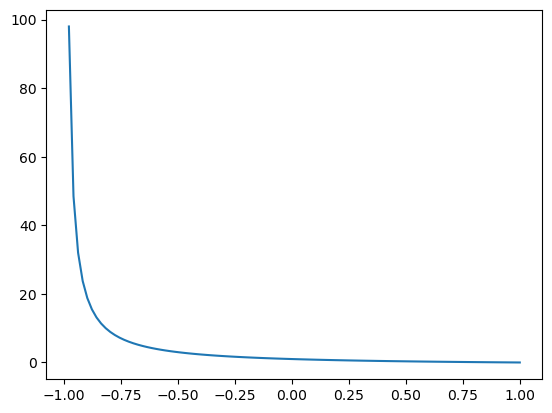

In [32]:
x = np.linspace(-1,1,100)[1:]
plt.plot(
    x,
    (1-x)/(1+x)
)
plt.show()

In [26]:
500*(1-0.9)/(1+0.9)

26.315789473684205

## Section 4.2

In [33]:
ar2_series = ARProcess([-0.4, 0.3]).generate(500)

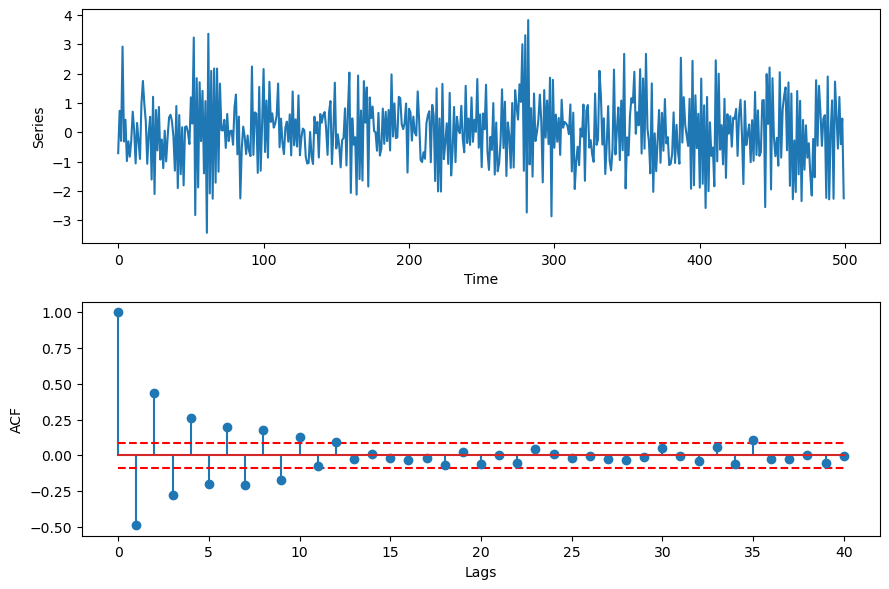

In [34]:
plot_acf(ar2_series)

In [35]:
ar2_series.mean()

0.031875670030839125

In [36]:
r_1 = acf(ar2_series, nlags = 40, fft = True)[1]
r_1

-0.4873785259809223

In [37]:
r_2 = acf(ar2_series,nlags = 40, fft = True)[2]
r_2

0.4344915324346277

In [38]:
alpha_hat_1 = r_1*(1-r_2)/(1-r_1**2)
alpha_hat_1

-0.36148243588217094

In [39]:
alpha_hat_2 = (r_2-r_1**2)/(1-r_1**2)
alpha_hat_2

0.25831275566638195

In [40]:
(alpha_hat_1 - 1.96/np.sqrt(500), alpha_hat_1 + 1.96/np.sqrt(500))

(-0.4491363006001627, -0.2738285711641792)

In [41]:
(alpha_hat_2 - 1.96/np.sqrt(500), alpha_hat_2 + 1.96/np.sqrt(500))

(0.1706588909483902, 0.3459666203843737)

Estimating via a linear regression

In [42]:
import matplotlib.pyplot as plt

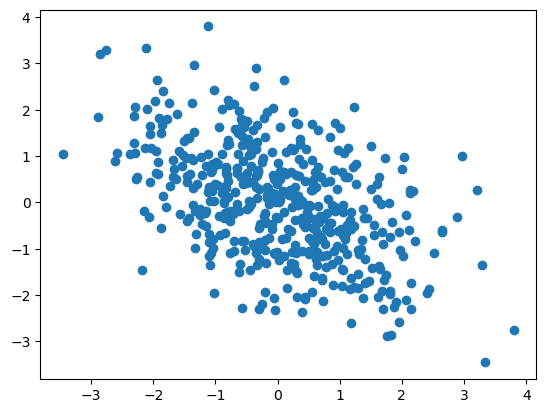

In [49]:
plt.scatter(ar2_series[1:-1], ar2_series[0:-2])
plt.show()

In [44]:
ar2_series_mean = ar2_series.mean()
ar2_series = ar2_series - ar2_series_mean
X = np.array([ar2_series[1:-1], ar2_series[0:-2]]).T
X = sm.add_constant(X)
ar2_linear_model = sm.OLS(ar2_series[2:].T, X)
ar2_results = ar2_linear_model.fit()
ar2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     101.2
Date:                Tue, 10 Aug 2021   Prob (F-statistic):           1.44e-37
Time:                        17:46:41   Log-Likelihood:                -702.64
No. Observations:                 498   AIC:                             1411.
Df Residuals:                     495   BIC:                             1424.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.045      0.030      0.976      -0.086       0.089
x1            -0.3633      0.044     -8.336      0.000      -0.449      -0.278
x2             0.2600      0.044      5.966      0.000       0.174       0.346
==============================================================================
Omnibus:                        2.339   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                2.409
Skew:                           0.161   Prob(JB):                        0.300
Kurtosis:                       2.891   Cond. No.                         1.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
sm.regression.yule_walker(ar2_series, order = 2)

(array([-0.36154111,  0.25967598]), 0.9910162669960686)

In [47]:
ar3_series = ARProcess([0.25, 0.5, -0.125]).generate(500)

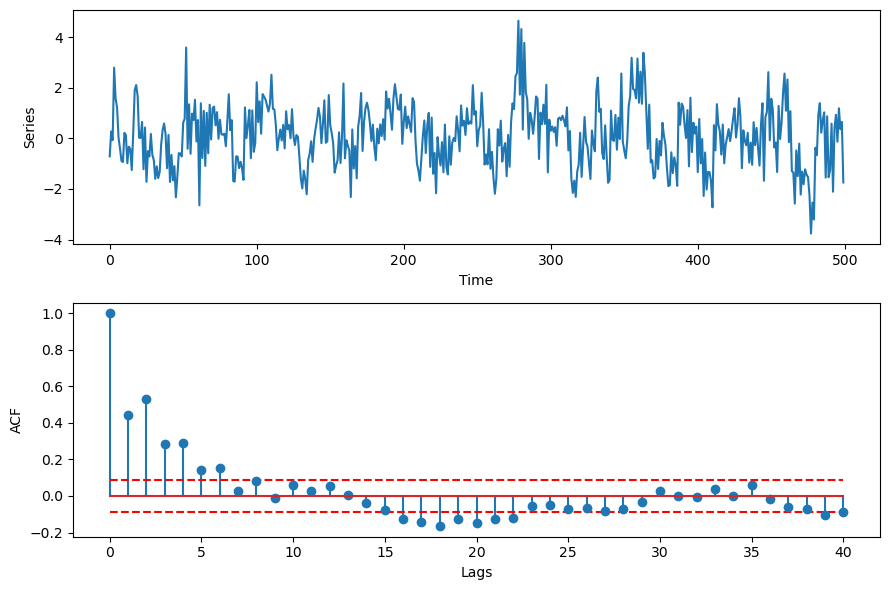

In [50]:
plot_acf(ar3_series)

In [51]:
ar3_series.mean()

0.10020048594026439

In [52]:
r_1 = acf(ar3_series, nlags = 40, fft = True)[1]
r_1

0.4415474798418242

In [53]:
r_2 = acf(ar3_series,nlags = 40, fft = True)[2]
r_2

0.5288285690412072

In [54]:
r_3 = acf(ar3_series,nlags = 40, fft = True)[2]
r_3

0.5288285690412072

In [55]:
series = ar3_series - ar3_series.mean()

In [56]:
X = np.array([series[2:-1], series[1:-2], series[0:-3]]).T

In [57]:
linear_model = sm.OLS(series[3:].T, X)

In [58]:
results = linear_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.337
Model:                            OLS   Adj. R-squared (uncentered):              0.333
Method:                 Least Squares   F-statistic:                              83.68
Date:                Tue, 10 Aug 2021   Prob (F-statistic):                    8.64e-44
Time:                        17:47:53   Log-Likelihood:                         -700.80
No. Observations:                 497   AIC:                                      1408.
Df Residuals:                     494   BIC:                                      1420.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2826      0.045      6.264      0.000       0.194       0.371
x2             0.4314      0.043     10.112      0.000       0.348       0.515
x3            -0.0575      0.045     -1.276      0.203      -0.146       0.031
==============================================================================
Omnibus:                        2.158   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                2.228
Skew:                           0.155   Prob(JB):                        0.328
Kurtosis:                       2.892   Cond. No.                         2.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
ar_mod = ARIMA(series, order = (3,0,0), trend = 'n')
ar_res = ar_mod.fit()
print(ar_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -704.176
Date:                Tue, 10 Aug 2021   AIC                           1416.352
Time:                        17:47:57   BIC                           1433.210
Sample:                             0   HQIC                          1422.967
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2817      0.043      6.490      0.000       0.197       0.367
ar.L2          0.4301      0.043     10.112      0.000       0.347       0.513
ar.L3         -0.0572      0.046     -1.256      0.2

In [60]:
sm.regression.yule_walker(ar3_series, order = 3)

(array([ 0.28078095,  0.43087602, -0.05458512]), 0.9882939041644381)

### Determining the order of an AR process

In [61]:
ar_series = ARProcess([1/4, 1/2, -1/8]).generate(500)

In [82]:
# Fitting with a regressino with
Y = [
        np.array(
            [ar_series[i-j: -j] for j in range(1, i+1)]
        ).T
    for i in range(1,11)
]   
Y = list(map(sm.add_constant, Y))

In [86]:
models = [sm.OLS(ar_series[i+1:].T, Y[i]) for i in range(10)]

In [87]:
results = [model.fit() for model in models]

In [88]:
for result in results:
    print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     121.2
Date:                Tue, 10 Aug 2021   Prob (F-statistic):           2.26e-25
Time:                        18:14:20   Log-Likelihood:                -750.71
No. Observations:                 499   AIC:                             1505.
Df Residuals:                     497   BIC:                             1514.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0557      0.049      1.137      0.2

In [90]:
Y = [
        np.array(
            [ar_series[i-j: -j] for j in range(1, i+1)]
        ).T
    for i in range(1,11)
]
models = [sm.OLS(ar_series[i+1:].T, Y[i]) for i in range(10)]
results = [model.fit() for model in models]
for result in results:
    print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.200
Model:                            OLS   Adj. R-squared (uncentered):              0.198
Method:                 Least Squares   F-statistic:                              124.2
Date:                Tue, 10 Aug 2021   Prob (F-statistic):                    6.71e-26
Time:                        18:19:35   Log-Likelihood:                         -751.36
No. Observations:                 499   AIC:                                      1505.
Df Residuals:                     498   BIC:                                      1509.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [92]:
for i in range(1, 11):
    ar_mod = ARIMA(ar_series, order = (i,0,0), trend = 'n')
    ar_res = ar_mod.fit()
    print(ar_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -752.648
Date:                Tue, 10 Aug 2021   AIC                           1509.295
Time:                        18:21:46   BIC                           1517.725
Sample:                             0   HQIC                          1512.603
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4469      0.038     11.840      0.000       0.373       0.521
sigma2         1.1880      0.075     15.897      0.000       1.042       1.334
Ljung-Box (L1) (Q):                  17.77   Jarque-